<a href="https://colab.research.google.com/github/Aasif23/llm-usage-visualizer/blob/main/ai_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualize your ChatGPT and Claude's usage.

This has two scripts:

  1.   Visualize only ChatGPT usage.
  
  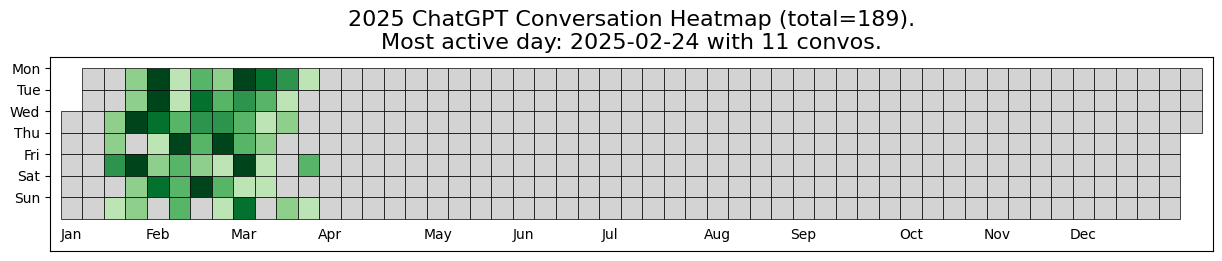
  
  2.  Compare your ChatGPT usage with Claude usage. It's interesting to see when you start switching from one to another.

  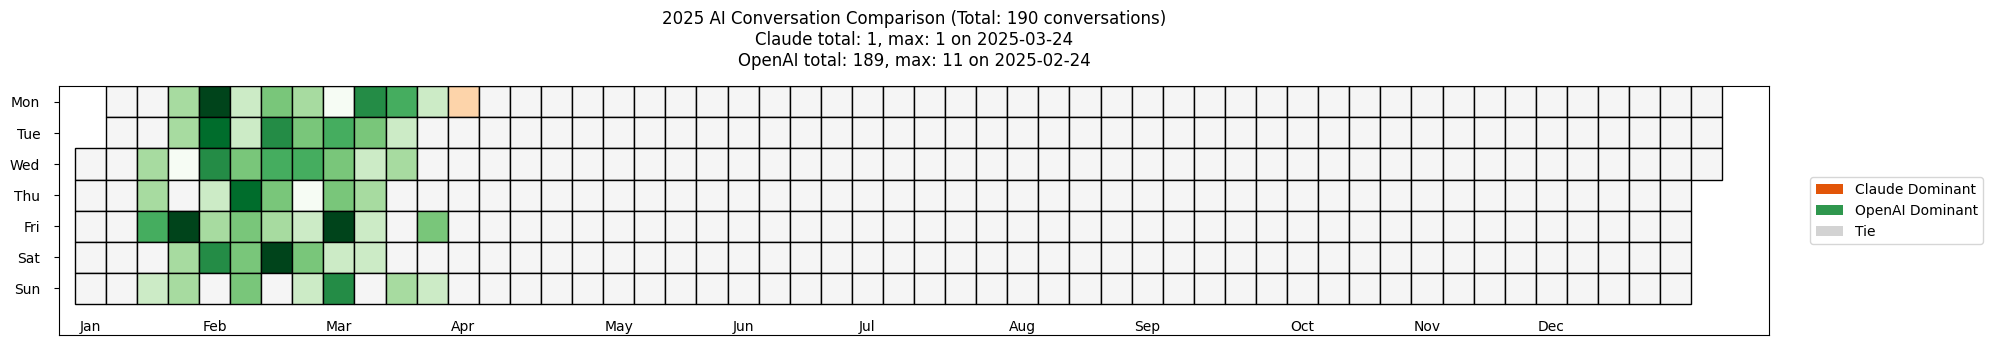




1. Visualize ChatGPT usage
  1. Export your ChatGPT conversations. From your ChatGPT account, go to Settings -> Data controls -> Export
  2. Unzip the data export
  3. Point convo_folder to your exported data folder
  



In [10]:
convo_folder = 'export_chatgpt'
local_tz = 'Asia/Kolkata' # Indian Standard Time

In [11]:
import json

with open(f'{convo_folder}/conversations.json', 'r') as f:
    oai_convs = json.load(f)

In [12]:
import pytz
from datetime import datetime, timezone

convo_folder = 'export_chatgpt'
local_tz = 'Asia/Kolkata'  # Indian Standard Time

oai_convo_times = []
for conv in oai_convs:
    # Given Unix timestamp
    unix_timestamp = conv['create_time']

    # Convert to UTC datetime
    utc_datetime = datetime.fromtimestamp(unix_timestamp, tz=timezone.utc)

    # Convert UTC datetime to local timezone (IST)
    ist_datetime = utc_datetime.astimezone(pytz.timezone(local_tz))
    oai_convo_times.append(ist_datetime)

In [14]:
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from datetime import datetime, timedelta

def create_year_heatmap(convo_times, year):
    # Convert convo_times to dates and filter for the given year
    just_dates = [convo.date() for convo in convo_times if convo.year == year]

    date_counts = Counter(just_dates)

    # Create a full year date range for the calendar
    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()

    total_days = (end_date - start_date).days + 1
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]

    # Prepare data for plotting
    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()
        count = date_counts.get(date, 0)
        data.append((week, day_of_week, count))

    weeks_in_year = (end_date - start_date).days // 7 + 1

    # Plot the heatmap
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')

    max_count_date = max(date_counts, key=date_counts.get)
    max_count = date_counts[max_count_date]
    p90_count = np.percentile(list(date_counts.values()), 90)
    for week, day_of_week, count in data:
        color = plt.cm.Greens((count + 1) / p90_count) if count > 0 else 'lightgray'
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    # Replace week numbers with month names below the heatmap
    month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                    if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, 7.75, month_start.strftime('%b'), ha='center', va='center', fontsize=10, rotation=0)

    # Adjustments for readability
    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    plt.title(
        f'{year} ChatGPT Conversation Heatmap (total={sum(date_counts.values())}).\nMost active day: {max_count_date} with {max_count} convos.',
        fontsize=16
    )
    plt.xticks([])
    plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.gca().invert_yaxis()
    plt.show()


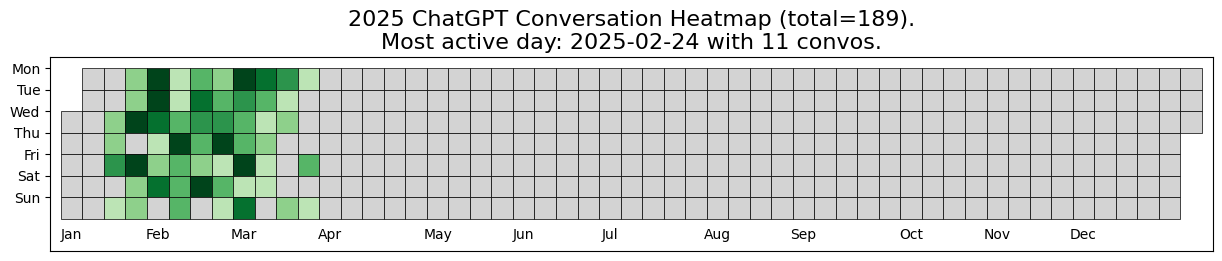

In [23]:
create_year_heatmap(oai_convo_times, 2025)

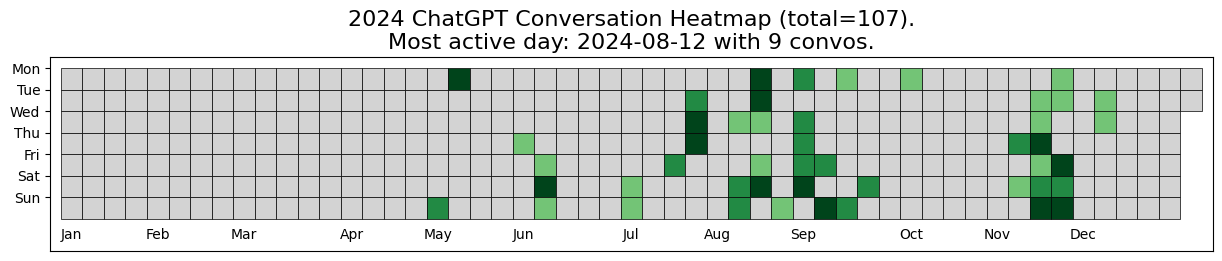

In [24]:
create_year_heatmap(oai_convo_times, 2024)

**2. Visualize ChatGPT vs. Claude usage**

  You can optionally add your Claude data as well, through the following step:

  1. Export your Claude conversations.
  2. From your Claude account, go to Settings -> Account -> Data -> Export data
  3. Unzip the downloaded data
  4. Point claude_convo_folder to your exported directory

In [15]:
claude_convo_folder = 'export_claude'

In [16]:
import json

with open(f'{claude_convo_folder}/conversations.json', 'r') as f:
    claude_convs = json.load(f)

In [17]:
def convert_claude_timestamps(convs, local_tz, claude=True):
    convo_times = []
    for conv in convs:
        # Parse ISO format string to datetime
        utc_datetime = datetime.strptime(conv['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")

        # Add UTC timezone info
        utc_datetime = utc_datetime.replace(tzinfo=timezone.utc)

        # Convert UTC to local timezone
        local_datetime = utc_datetime.astimezone(pytz.timezone(local_tz))
        convo_times.append(local_datetime)

    return convo_times

In [18]:
claude_convo_times = convert_claude_timestamps(claude_convs, local_tz)

In [19]:
def create_comparison_heatmap(claude_times, openai_times, year):
    # Convert times to dates and filter for the given year
    claude_dates = [convo.date() for convo in claude_times if convo.year == year]
    openai_dates = [convo.date() for convo in openai_times if convo.year == year]

    claude_counts = Counter(claude_dates)
    openai_counts = Counter(openai_dates)

    # Calculate totals
    claude_total = sum(claude_counts.values())
    openai_total = sum(openai_counts.values())
    combined_total = claude_total + openai_total

    # Create a full year date range
    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()
    total_days = (end_date - start_date).days + 1
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]

    # Prepare data for plotting - Reverse the day_of_week calculation
    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        # Reverse the order: 0 (Mon) -> 6, 1 (Tue) -> 5, etc.
        day_of_week = 6 - date.weekday()  # This reverses the order
        claude_count = claude_counts.get(date, 0)
        openai_count = openai_counts.get(date, 0)
        dominant_llm = 'claude' if claude_count > openai_count else 'openai' if openai_count > claude_count else 'tie'
        count = max(claude_count, openai_count)
        data.append((week, day_of_week, count, dominant_llm))

    weeks_in_year = (end_date - start_date).days // 7 + 2

    # Calculate overall p90 for color scaling
    all_counts = list(claude_counts.values()) + list(openai_counts.values())
    p90_count = np.percentile(all_counts, 90) if all_counts else 1

    # Plot setup
    plt.figure(figsize=(20, 8))
    ax = plt.gca()
    ax.set_aspect('equal')

    # Plot rectangles
    for week, day_of_week, count, dominant_llm in data:
        if count > 0:
            # Start at 0.1 (10%) intensity and scale up to 1
            intensity = min(0.1 + (count / p90_count * 0.9), 1)
            color = plt.cm.Oranges(intensity) if dominant_llm == 'claude' else \
                   plt.cm.Greens(intensity) if dominant_llm == 'openai' else \
                   'lightgray'
        else:
            color = '#F5F5F5'  # Light gray for empty cells

        rect = patches.Rectangle(
            (week, day_of_week), 1, 1,
            linewidth=1,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(rect)

    # Add month labels
    month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                   if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, -0.5, month_start.strftime('%b'),
                ha='center', va='top', fontsize=10)

    # Find most active days
    claude_max_date = max(claude_counts.items(), key=lambda x: x[1]) if claude_counts else (None, 0)
    openai_max_date = max(openai_counts.items(), key=lambda x: x[1]) if openai_counts else (None, 0)

    # Title and formatting
    plt.title(
        f'{year} AI Conversation Comparison (Total: {combined_total:,} conversations)\n'
        f'Claude total: {claude_total:,}, max: {claude_max_date[1]} on {claude_max_date[0]}\n'
        f'OpenAI total: {openai_total:,}, max: {openai_max_date[1]} on {openai_max_date[0]}',
        fontsize=12, pad=15
    )

    # Adjust axis limits and labels
    plt.xlim(-0.5, weeks_in_year + 0.5)
    plt.ylim(-1, 7)
    plt.xticks([])

    # Set y-ticks at the center of each box (offset by 0.5)
    plt.yticks([i + 0.5 for i in range(7)], ['Sun', 'Sat', 'Fri', 'Thu', 'Wed', 'Tue', 'Mon'])

    # Adjust y-axis label positioning
    ax.yaxis.set_tick_params(pad=10)

    # Add legend
    legend_elements = [
        patches.Patch(facecolor=plt.cm.Oranges(0.7), label='Claude Dominant'),
        patches.Patch(facecolor=plt.cm.Greens(0.7), label='OpenAI Dominant'),
        patches.Patch(facecolor='lightgray', label='Tie')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout()
    plt.show()


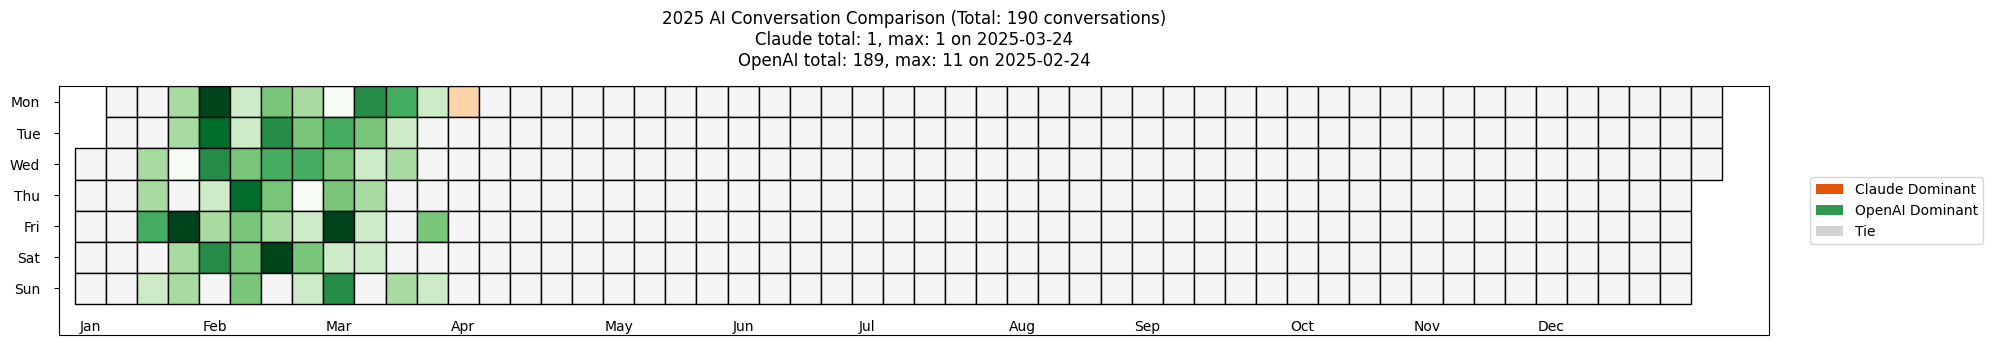

In [20]:
create_comparison_heatmap(claude_convo_times, oai_convo_times, 2025)

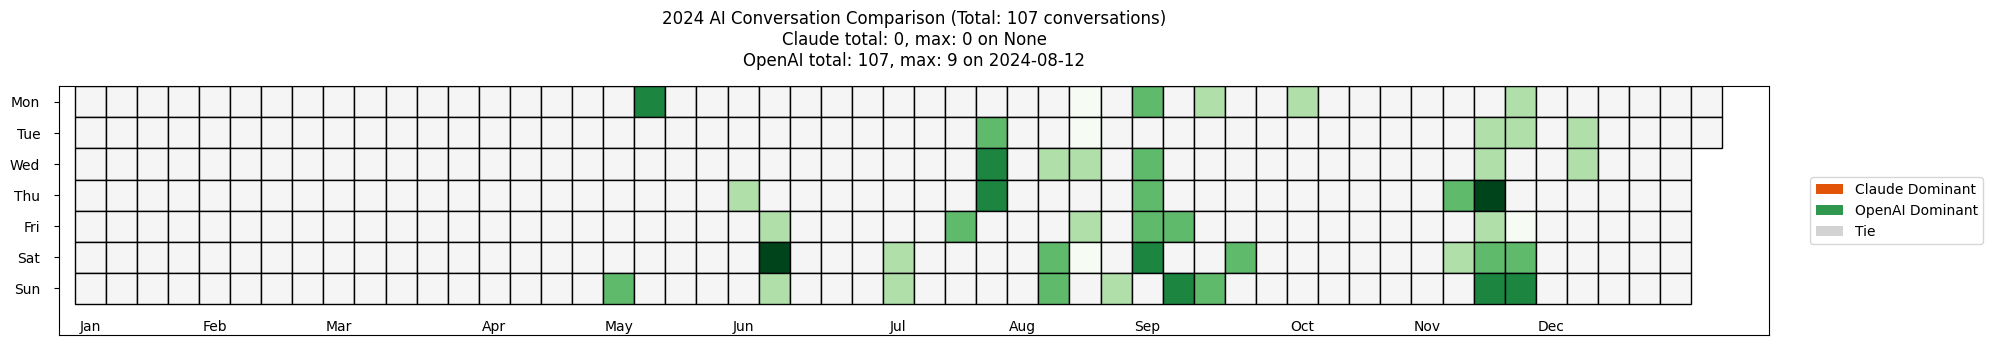

In [21]:
create_comparison_heatmap(claude_convo_times, oai_convo_times, 2024)